This is a list of all the libraries that are used in this analysis

In [31]:
from basketball_reference_web_scraper import client
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, silhouette_score
import numpy as np
from scipy.stats import pearsonr

Right now the data is imported from two excels which have advanced stats and player totals for the season. This will probably chance in the furture to getting data from basketball-reference.com. I also need to merge the two dataframes and remove duplicates. The duplicates occur when a player is traded from one team to another in the middle of the season.

In [32]:
df_advanced = pd.read_excel('Advanced Stats.xlsx')
df_total_stats = pd.read_excel('Total Stats.xlsx')
df = df_advanced.merge(df_total_stats, on = ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'Rk'])
df.drop_duplicates(['Player'], keep='first',inplace=True)

I am going to make a copy of the original df since I will remove some columns (Player name, position, team, age etc.) as they aren't important for analysis. I will need the player name later on to see which players cluster together. There are also some columns with NAs which I will drop as well as players with total time played less than 1000  minutes.

In [33]:
df.dropna(axis=1,inplace=True)
idx = df.index[df['MP']<1000]
df.drop(idx,inplace=True)
idx_gp = df.index[df['G']<50]
df.drop(idx_gp,inplace=True)
df_copy = df.copy(deep=True)
df.drop(['Pos', 'Rk', 'Tm', 'Player'],axis=1,inplace=True)

I am going to split the data into a train/test set. Since I want to keep a track of the training data in the original data frame, I will create a dummy array and split it then use those indices to split the dataframe.

In [34]:
indices = np.arange(0,np.shape(df)[0])
indices_train, indices_test  = train_test_split(indices, test_size=0.0)
train_df = df.iloc[indices_train,:]
test_df = df.iloc[indices_test,:]
train_df_copy = df_copy.iloc[indices_train,:]
test_df_copy = df_copy.iloc[indices_test,:]

Since there are 37 features, Ill use PCA for dimensionality reduction. But first, the data needs to be standardized

In [35]:
scaler = preprocessing.StandardScaler()
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df),columns=df.columns)

C:\Users\Manik.Rajora\AppData\Local\conda\conda\envs\Py36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Manik.Rajora\AppData\Local\conda\conda\envs\Py36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


For PCA we need to determine the number of compopnents. Here, I used the explained variance ratio to determine the number of components

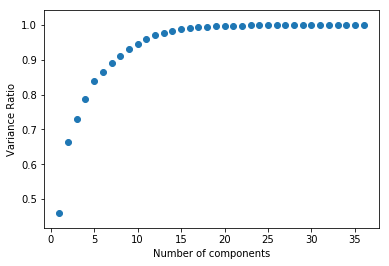

In [36]:
evr = []
for components in range(1, np.shape(train_df_scaled)[1]):
    pca = PCA(n_components=components)
    pca.fit(train_df_scaled)
    if components == 1:
        evr.append(pca.explained_variance_ratio_[-1])
    else:
        evr.append(evr[-1]+pca.explained_variance_ratio_[-1])

plt.scatter(np.arange(1,np.shape(df)[1]),evr)
plt.xlabel('Number of components')
plt.ylabel('Variance Ratio')
plt.show()
#     kmeans = KMeans(n_clusters=n_cluster,random_state=1).fit(X_train)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(X_train, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

Seems like 16 is a good number of components to use. Now we can check the correlation between the principal components and the original features.

Next, we need to determine the number of clusters. We can do this by using the Silhouette Measure and Elbow Method.

For n_clusters=2, The Silhouette Coefficient is 0.32847493288997265
For n_clusters=3, The Silhouette Coefficient is 0.2914035559387406
For n_clusters=4, The Silhouette Coefficient is 0.19556418547519583
For n_clusters=5, The Silhouette Coefficient is 0.18190364547621457
For n_clusters=6, The Silhouette Coefficient is 0.1615468573075712
For n_clusters=7, The Silhouette Coefficient is 0.1532125684943959
For n_clusters=8, The Silhouette Coefficient is 0.12804471899222683
For n_clusters=9, The Silhouette Coefficient is 0.11661322200308297
For n_clusters=10, The Silhouette Coefficient is 0.11947322098437703
For n_clusters=11, The Silhouette Coefficient is 0.11012491581967931
For n_clusters=12, The Silhouette Coefficient is 0.11328632279334373
For n_clusters=13, The Silhouette Coefficient is 0.11068825970685965
For n_clusters=14, The Silhouette Coefficient is 0.11586045328900937
For n_clusters=15, The Silhouette Coefficient is 0.12057479390038132
For n_clusters=16, The Silhouette Coefficient

No handles with labels found to put in legend.


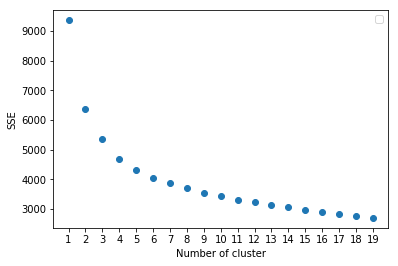

In [37]:
pca = PCA(n_components=15)
reduced_features = pca.fit_transform(train_df_scaled)

for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster).fit(reduced_features)
    label = kmeans.labels_
    sil_coeff = silhouette_score(reduced_features, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k).fit(reduced_features)
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'o')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.xticks(list(sse.keys()))
plt.legend()
plt.show()

Its a bit hard to interprety the silhouette measure but using the elbow method shows that 13 clusters is a good choice. Now to see what players are grouped together in our clusters

In [38]:
kmeans = KMeans(n_clusters=11).fit(reduced_features)
labels = kmeans.labels_ 
train_df_copy['labels'] = labels
names = {}
unique_labels = list(set(labels))
for i in range(len(unique_labels)):
    names[i] = train_df_copy[train_df_copy['labels']==unique_labels[i]]['Player']

C:\Users\Manik.Rajora\AppData\Local\conda\conda\envs\Py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
display(names[4])

540         Jakob Poeltl
678     Hassan Whiteside
407         Kevon Looney
498          Larry Nance
10         Jarrett Allen
315          Serge Ibaka
652         Myles Turner
4            Bam Adebayo
548        Dwight Powell
448         JaVale McGee
503         Nerlens Noel
163             Ed Davis
567    Mitchell Robinson
360       DeAndre Jordan
214       Derrick Favors
538        Mason Plumlee
Name: Player, dtype: object

In [449]:
pca = PCA(n_components=16)
reduced_features = pca.fit_transform(train_df_scaled)
corr_coeff = np.zeros((np.shape(reduced_features)[1],np.shape(train_df_scaled)[1]))
for i in range(np.shape(reduced_features)[1]):
    for j in range(np.shape(train_df_scaled)[1]):
        corr_coeff[i,j] = pearsonr(train_df_scaled.iloc[:,j],reduced_features[:,i])[0]
display(corr_coeff)

array([[-1.84745036e-02,  3.69362624e-01,  7.25547466e-01,
         8.81007799e-01,  4.07989452e-01,  5.41571620e-01,
         5.28152442e-01,  3.33408198e-01,  2.28577149e-01,
         3.85189481e-01,  5.96598820e-01,  8.53609817e-01,
         7.72524184e-01,  9.12394818e-01,  7.63148191e-01,
         7.53773551e-01,  4.90913446e-01,  8.36124104e-01,
         8.90846882e-01,  6.34447834e-01,  8.69901336e-01,
         7.60224361e-01,  2.02489579e-01,  2.06402937e-01,
         8.79592882e-01,  8.34750573e-01,  8.34550040e-01,
         8.61206557e-01,  6.32666292e-01,  8.46395912e-01,
         8.28135780e-01,  5.39447004e-01,  5.79650013e-01,
         5.98956442e-01,  7.62056233e-01,  6.25296256e-01,
         8.55348729e-01],
       [ 1.54386366e-01,  1.02565103e-01,  4.05176138e-01,
        -1.53007185e-01, -8.02511562e-01, -6.58959471e-01,
        -7.59114573e-01,  5.23009196e-01,  1.33538574e-01,
        -7.04375015e-01,  4.47754000e-01, -4.26954319e-02,
        -2.08456881e-01, -1.06